In [2]:
import pandas as pd
import numpy as np
!python3 -m pip install scikit-learn
!pip install xgboost
import xgboost as xgb

In [94]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=100,
    reg_alpha=1,
    reg_lambda=10,
    subsample=1.0
)

split = TimeSeriesSplit(n_splits = 3)
sfs = SequentialFeatureSelector(xgb_model, n_features_to_select=10, direction="forward", cv=split)

In [74]:
from sklearn.model_selection import GridSearchCV

param_search = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 1, 10],
    'reg_alpha': [0, 1, 10]
}

gsearch = GridSearchCV(estimator=xgb_model, param_grid=param_search, cv=split)

In [76]:
def backtest(data, model, predictors, start = 44, step = 1):
    all_predictions = []

    days = sorted(data["Date"].unique())

    for i in range(start, len(days), step):
        day = days[i]

        train = data[data["Date"] < day]
        test = data[data["Date"] == day]

        model.fit(train[predictors], train["Target"])

        pred = model.predict(test[predictors])
        pred_proba = model.predict_proba(test[predictors])[:, 1]
        
        test = test.reset_index(drop=True)
        pred = pd.Series(pred).reset_index(drop=True)
        pred_proba = pd.Series(pred_proba).reset_index(drop=True)
        
        combined = pd.concat([test["Team_x"], test["Opp_next_x"], test["Date_next"], test["Odds_next_use"], test["Wins_use"], test["Target"], pd.Series(pred), pd.Series(pred_proba)], axis=1)
        combined.columns = ["Team", "Opp", "Date", "Odds", "Wins", "Actual", "Prediction", "Probability"]

        all_predictions.append(combined)
    
    return pd.concat(all_predictions)

In [12]:
df = pd.read_csv("full.csv")
df_test = pd.read_csv("full_test_23.csv")

In [14]:
def remove_unnamed_columns(df1):
  columns_to_remove = [col for col in df1.columns if "Unnamed" in col]
  df1.drop(columns_to_remove, axis=1, inplace=True)
  return df1
df = remove_unnamed_columns(df)
df_test = remove_unnamed_columns(df_test)

In [16]:
removed = ["Team", "Opp", "NumWL", "Date", "Target", "Record", "Date_next"]
removed = list(df.columns[df.dtypes == "object"]) + removed
removed.append("Date_next")
removed.append("Home/Away")
removed.append("MIN")
removed.append("MIN_10_x")
removed.append("MIN_10_y")
removed.append("Wins_use")
removed.append("Odds_next_use")
removed.append("Odds_use")

In [18]:
selected = df.columns[~df.columns.isin(removed)]

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[selected] = scaler.fit_transform(df[selected])
df_test[selected] = scaler.fit_transform(df_test[selected])

In [22]:
pd.set_option('display.max_columns', None)
df.head()

,Team_x,Opp,Home/Away,Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-,OffRtg,DefRtg,NetRtg,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TOV%,eFG%,TS%,PACE,PIE,NumWL,Record,ELO,Odds,Target,Form,Wins,Losses,Odds_use,Wins_use,Home/Away_10_x,W/L_10_x,MIN_10_x,PTS_10_x,FGM_10_x,FGA_10_x,FG%_10_x,3PM_10_x,3PA_10_x,3P%_10_x,FTM_10_x,FTA_10_x,FT%_10_x,OREB_10_x,DREB_10_x,REB_10_x,AST_10_x,STL_10_x,BLK_10_x,TOV_10_x,PF_10_x,+/-_10_x,OffRtg_10_x,DefRtg_10_x,NetRtg_10_x,AST%_10_x,AST/TO_10_x,AST Ratio_10_x,OREB%_10_x,DREB%_10_x,REB%_10_x,TOV%_10_x,eFG%_10_x,TS%_10_x,PACE_10_x,PIE_10_x,ELO_10_x,Odds_10_x,Form_10_x,Wins_10_x,Losses_10_x,Home_next,Opp_next_x,Date_next,Odds_next,Odds_next_use,Home/Away_10_y,W/L_10_y,MIN_10_y,PTS_10_y,FGM_10_y,FGA_10_y,FG%_10_y,3PM_10_y,3PA_10_y,3P%_10_y,FTM_10_y,FTA_10_y,FT%_10_y,OREB_10_y,DREB_10_y,REB_10_y,AST_10_y,STL_10_y,BLK_10_y,TOV_10_y,PF_10_y,+/-_10_y,OffRtg_10_y,DefRtg_10_y,NetRtg_10_y,AST%_10_y,AST/TO_10_y,AST Ratio_10_y,OREB%_10_y,DREB%_10_y,REB%_10_y,TOV%_10_y,eFG%_10_y,TS%_10_y,PACE_10_y,PIE_10_y,ELO_10_y,Odds_10_y,Form_10_y,Wins_10_y,Losses_10_y,Opp_next_y,Team_y
0,ATL,CHA,0,10/25/23,0.0,0.0,0.440476,0.333333,0.48,0.296830,0.12,0.306122,0.181658,0.595238,0.612245,0.727136,0.428571,0.342105,0.346939,0.333333,0.60,0.058824,0.346154,0.423077,0.450000,0.356041,0.437262,0.449565,0.522763,0.126404,0.361905,0.499018,0.402750,0.373684,0.361233,0.221176,0.3075,0.672131,0.416949,"(0, 1)","(0, 1)",0.487703,0.693000,0,0.519061,0.000000,0.014706,-175,0,0.5,0.3,0.25,0.639205,0.525180,0.813187,0.315828,0.299145,0.489247,0.209404,0.802469,0.882353,0.555645,0.660377,0.458015,0.613924,0.456522,0.416667,0.241935,0.264706,0.469565,0.236318,0.465888,0.880293,0.248677,0.371138,0.418935,0.363853,0.598655,0.770900,0.567506,0.175205,0.261828,0.341927,0.819134,0.266919,0.400187,0.621603,0.473082,0.253119,0.341098,1.0,NYK,10/27/23,0.708361,-105,0.6,0.9,0.00,0.551136,0.482014,0.494505,0.501094,0.606838,0.569892,0.761129,0.462963,0.452941,0.687981,0.575472,0.633588,0.702532,0.442029,0.541667,0.306452,0.225490,0.295652,0.925373,0.722803,0.087948,0.918711,0.394212,0.493295,0.520809,0.732063,0.706445,0.816171,0.240779,0.585224,0.605156,0.191336,0.882158,0.694699,0.526891,0.249845,0.385027,0.222962,ATL,NYK
1,NOP,MEM,0,10/25/23,1.0,0.0,0.452381,0.358974,0.32,0.446686,0.48,0.367347,0.650794,0.357143,0.387755,0.659670,0.392857,0.631579,0.551020,0.282051,0.40,0.294118,0.692308,0.500000,0.558333,0.381748,0.291508,0.567826,0.420722,0.037453,0.323810,0.512770,0.587426,0.628947,0.753304,0.472941,0.4925,0.655738,0.572881,"(1, 0)","(1, 0)",0.548104,0.709239,1,0.234247,0.015625,0.000000,-101,1,0.4,0.6,0.00,0.482955,0.517986,0.412088,0.589351,0.478632,0.354839,0.773668,0.345679,0.394118,0.435451,0.471698,0.793893,0.765823,0.434783,0.305556,0.516129,0.558824,0.417391,0.579602,0.519975,0.387622,0.582973,0.347673,0.259651,0.464923,0.685538,0.916401,0.946606,0.565574,0.614388,0.590909,0.444043,0.576905,0.637402,0.642068,0.358306,0.365419,0.241265,1.0,NYK,10/28/23,0.700022,-143,0.6,0.9,0.00,0.602273,0.503597,0.516484,0.510576,0.692308,0.650538,0.830094,0.475309,0.505882,0.593687,0.584906,0.648855,0.721519,0.507246,0.555556,0.274194,0.245098,0.365217,0.927861,0.731407,0.084283,0.927369,0.461869,0.508736,0.563615,0.682175,0.760689,0.800915,0.240779,0.627997,0.635007,0.296029,0.866540,0.676091,0.529710,0.264462,0.338681,0.196339,NOP,NYK
2,MEM,NOP,1,10/25/23,0.0,0.0,0.369048,0.307692,0.44,0.293948,0.40,0.591837,0.370370,0.333333,0.346939,0.700150,0.285714,0.315789,0.244898,0.307692,0.40,0.411765,0.384615,0.423077,0.441667,0.281491,0.390368,0.432174,0.507064,0.104869,0.347619,0.412574,0.487230,0.371053,0.405286,0.310588,0.3300,0.655738,0.427119,"(0, 1)","(0, 1)",0.487703,0.705508,0,0.380753,0.000000,0.014706,-118,0,0.4,0.6,0.00,0.380682,0.309353,0.467033,0.312910,0.606838,0.666667,0.649530,0.388889,0.447059,0.394172,0.500000,0.549618,0.582278,0.514493,0.527778,0.500000,0.588235,0.504348,0.529851,0.364474,0.29275

In [24]:
df.shape

(2116, 138)

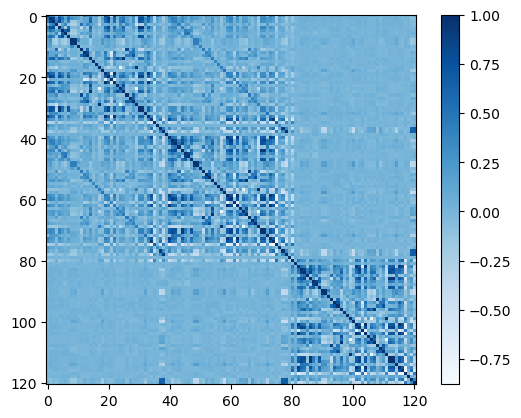

In [54]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd

matrix = df[selected].corr()

plt.imshow(matrix, cmap='Blues')

plt.colorbar()

variables = []
for i in matrix.columns:
    variables.append(i)


plt.savefig("correlation_matrix.png")

# Display the plot
plt.show()

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA

X = df[selected]
y = df['Target']
other_cols = ["Team_x", "Date", "Opp_next_x", "Date_next", "Odds_next_use", "Wins_use"]

pca = PCA(n_components=121)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

data_pca = pd.concat([pca_df, y, df[other_cols]], axis=1)

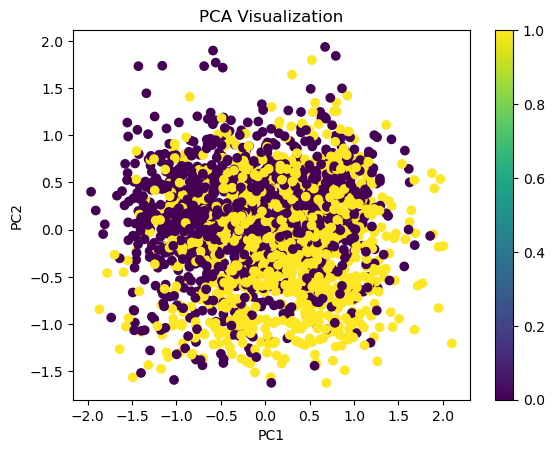

In [166]:
plt.scatter(data_pca['PC1'], data_pca['PC2'], c=data_pca['Target'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization')
plt.colorbar()
plt.savefig("pca.png")
plt.show()

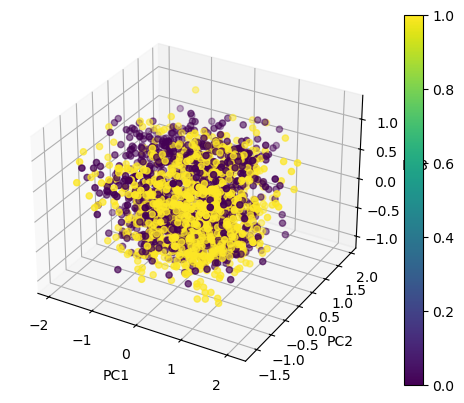

In [162]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = data_pca['PC1']
y = data_pca['PC2']
z = data_pca['PC3']
c = data_pca['Target']

scatter = ax.scatter(x, y, z, c=c, cmap='viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.colorbar(scatter)
plt.show()

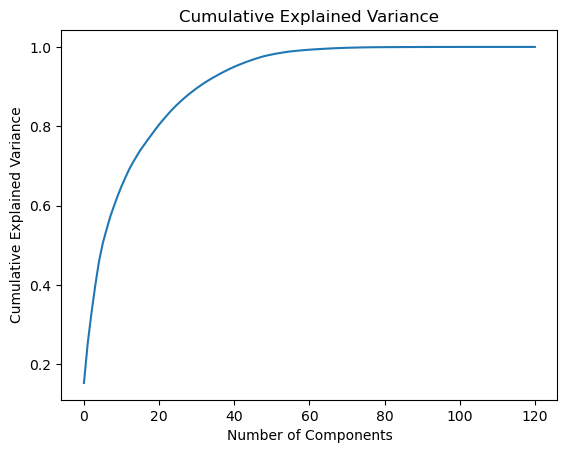

In [90]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_var_exp = np.cumsum(explained_variance_ratio)
plt.plot(range(len(cumulative_var_exp)), cumulative_var_exp)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

In [842]:
sfs.fit(df[selected], df["Target"])

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, grow_p...
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=None, ...),
                          n_features_to_select=10)

In [844]:
predictors = list(selected[sfs.get_support()])

In [846]:
predictors

['FGM',
 'TOV',
 'DREB%',
 'TOV%',
 'PIE_10_x',
 'ELO_10_x',
 'Home/Away_10_y',
 '3PA_10_y',
 'NetRtg_10_y',
 'ELO_10_y']

In [848]:
# predictors = ['W/L',
#  'FGM',
#  'OREB_10_y',
#  'STL_10_y',
#  'ELO_10_x',
#  '3PM_10_x',
#  'Odds_next', "Home/Away_10_x", "W/L_10_x", "Home_next"]

In [850]:
gsearch.fit(df[predictors], df["Target"])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 1, 10], 'reg_lambda': [0, 1, 10],
                         'subsample': [0.8, 1.0]})

In [852]:
best_model = gsearch.best_estimator_
best_params = gsearch.best_params_

In [855]:
print("Best hyperparameters:", best_params)

Best hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1.0}


In [136]:
p = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

In [138]:
predictions_pca = backtest(data_pca, xgb_model, p)

In [140]:
from sklearn.metrics import accuracy_score

predictions_pca = predictions_pca[predictions_pca["Actual"] != 2]
accuracy_score(predictions_pca["Actual"], predictions_pca["Prediction"])

0.644474034620506

In [142]:
df1 = predictions_pca[(predictions_pca['Probability'] < 0.40) | (predictions_pca['Probability'] > 0.60)]
df1["Date"] = pd.to_datetime(df1["Date"], infer_datetime_format=True)
df1 = df1.sort_values(by='Date')
df2 = df1
df2 = df2.rename(columns={'Team': 'Opp', 'Opp': 'Team'})
df1 = df1.merge(df2, how = "inner", on = ["Team", "Date"])
df1 = remove_new_columns(df1)
df1.columns = ['Team', 'Opp', 'Date', 'Odds', 'Wins', 'Actual', 'Prediction', 'Probability']
df1 = df1[df1["Actual"] != 2]
accuracy_score(df1["Actual"], df1["Prediction"])

/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_1554/3788635883.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df1["Date"] = pd.to_datetime(df1["Date"], infer_datetime_format=True)
/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_1554/3788635883.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1["Date"] = pd.to_datetime(df1["Date"], infer_datetime_format=True)
/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_1554/3788635883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

0.7239819004524887

In [144]:
cleaned_df = clean_data1(df1)
df1 = clean_data2(df1)
del df1["Game"]
df1 = df1[df1["Actual"] != 2]
accuracy_score(df1["Actual"], df1["Prediction"])

0.7578125

In [146]:
df1.shape

(768, 8)

In [854]:
predictions = backtest(df, best_model, predictors)

In [858]:
from sklearn.metrics import accuracy_score

predictions = predictions[predictions["Actual"] != 2]
accuracy_score(predictions["Actual"], predictions["Prediction"])

0.6571238348868176

In [882]:
df1 = predictions[(predictions['Probability'] < 0.40) | (predictions['Probability'] > 0.60)]

In [884]:
df1["Date"] = pd.to_datetime(df1["Date"], infer_datetime_format=True)

/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_4026/2656295559.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df1["Date"] = pd.to_datetime(df1["Date"], infer_datetime_format=True)
/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_4026/2656295559.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1["Date"] = pd.to_datetime(df1["Date"], infer_datetime_format=True)
/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_4026/2656295559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [886]:
df1 = df1.sort_values(by='Date')

In [888]:
df2 = df1
df2 = df2.rename(columns={'Team': 'Opp', 'Opp': 'Team'})
df1 = df1.merge(df2, how = "inner", on = ["Team", "Date"])

In [112]:
def remove_new_columns(df3):
    columns_to_remove = [col for col in df3.columns if "_y" in col] 
    df3.drop(columns_to_remove, axis=1, inplace=True) 
    return df3 
df1 = remove_new_columns(df1)

In [892]:
df1.columns = ['Team', 'Opp', 'Date', 'Odds', 'Wins', 'Actual', 'Prediction', 'Probability']

In [894]:
df1

,Team,Opp,Date,Odds,Wins,Actual,Prediction,Probability
0,IND,SAS,2023-11-06,-357,2,1,1,0.923723
1,ORL,DAL,2023-11-06,-108,3,0,0,0.238750
2,DET,GSW,2023-11-06,298,2,0,0,0.291291
3,GSW,DET,2023-11-06,-385,5,1,1,0.803788
4,DAL,ORL,2023-11-06,-108,5,1,1,0.837143
...,...,...,...,...,...,...,...,...
893,LAL,NOP,2024-04-14,100,46,1,1,0.775140
894,POR,SAC,2024-04-14,974,21,0,0,0.193756
895,GSW,UTA,2024-04-14,-556,45,1,1,0.908658
896,MEM,DEN,2024-04-14,604,27,0,0,0.065365


In [896]:
df1 = df1[df1["Actual"] != 2]
accuracy_score(df1["Actual"], df1["Prediction"])

0.7338530066815144

In [114]:
def clean_data1(df3):

  # Create a combined column of Team and Opponent to identify games
  df3['Game'] = df3[['Team', 'Opp']].apply(lambda x: tuple(sorted(x)), axis=1)

  # Group by Game and filter rows where Prediction is not the same
  df3 = df3.groupby('Game').filter(lambda x: x['Prediction'].nunique() > 1)


  return df3

In [900]:
cleaned_df = clean_data1(df1)

In [116]:
def clean_data2(df3):

  df3 = df3.groupby(['Game', 'Date']).filter(lambda x: x['Prediction'].nunique() > 1)

  return df3

In [904]:
df1 = clean_data2(df1)

In [906]:
del df1["Game"]

In [908]:
df1 = df1[df1["Actual"] != 2]
accuracy_score(df1["Actual"], df1["Prediction"])

0.7524038461538461

In [910]:
df1.shape

(832, 8)

In [912]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Date_next'] = pd.to_datetime(df_test['Date_next'])

In [914]:
df_test = remove_unnamed_columns(df_test)

In [916]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_test[selected] = scaler.fit_transform(df_test[selected])

In [918]:
new_predictions = backtest(df_test, best_model, predictors)

In [919]:
new_predictions.head(2)

,Team,Opp,Date,Odds,Wins,Actual,Prediction,Probability
0,SAS,HOU,2022-12-08,108,6,1,1,0.720742
1,DEN,DAL,2022-12-06,-185,14,0,1,0.630924


In [922]:
from sklearn.metrics import accuracy_score

new_predictions = new_predictions[new_predictions["Actual"] != 2]
accuracy_score(new_predictions["Actual"], new_predictions["Prediction"])

0.574585635359116

In [924]:
df_new = new_predictions[(new_predictions['Probability'] < 0.4) | (new_predictions['Probability'] > 0.6)]
df_new["Date"] = pd.to_datetime(df_new["Date"], infer_datetime_format=True)
df_new = df_new.sort_values(by='Date')

/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_4026/650097830.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_new["Date"] = pd.to_datetime(df_new["Date"], infer_datetime_format=True)
/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_4026/650097830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Date"] = pd.to_datetime(df_new["Date"], infer_datetime_format=True)


In [926]:
df2 = df_new
df2 = df2.rename(columns={'Team': 'Opp', 'Opp': 'Team'})
df_new = df_new.merge(df2, how = "inner", on = ["Team", "Date"])

In [928]:
df_new = remove_new_columns(df_new)

In [930]:
df_new.columns = ['Team', 'Opp', 'Date', 'Odds', 'Wins', 'Actual', 'Prediction', 'Probability']

In [932]:
df_new = df_new[df_new["Actual"] != 2]
accuracy_score(df_new["Actual"], df_new["Prediction"])

0.6290322580645161

In [934]:
cleaned_df_new = clean_data1(df_new)

In [936]:
df_new = clean_data2(df_new)

In [938]:
del df_new["Game"]

In [940]:
df_new = df_new[df_new["Actual"] != 2]
accuracy_score(df_new["Actual"], df_new["Prediction"])

0.6496598639455783

In [942]:
df_new.shape

(588, 8)

In [944]:
pd.set_option('display.max_rows', 500)
df_new.shape

(588, 8)

In [946]:
predictors

['FGM',
 'TOV',
 'DREB%',
 'TOV%',
 'PIE_10_x',
 'ELO_10_x',
 'Home/Away_10_y',
 '3PA_10_y',
 'NetRtg_10_y',
 'ELO_10_y']

In [948]:
import numpy as np

def wins_odds(df1):
    df1['Wins_prediction'] = np.where(
        df1['Wins'] > df1.apply(lambda x: df1[(df1['Date'] == x['Date']) & (df1['Team'] == x['Opp'])]['Wins'].iloc[0], axis=1),
        1,
        np.where(
            df1['Wins'] < df1.apply(lambda x: df1[(df1['Date'] == x['Date']) & (df1['Team'] == x['Opp'])]['Wins'].iloc[0], axis=1),
            0,
            2
        )
    )
    return df1

In [950]:
def pred_odds(df1):
    df1['Odds_prediction'] = np.where(
        df1['Odds'] < df1.apply(lambda x: df1[(df1['Date'] == x['Date']) & (df1['Team'] == x['Opp'])]['Odds'].iloc[0], axis=1),
        1,
        np.where(
            df1['Odds'] > df1.apply(lambda x: df1[(df1['Date'] == x['Date']) & (df1['Team'] == x['Opp'])]['Odds'].iloc[0], axis=1),
            0,
            2
        )
    )
    return df1

In [952]:
df4 = new_predictions[(new_predictions['Probability'] < 0.51) | (new_predictions['Probability'] > 0.49)]
df4["Date"] = pd.to_datetime(df4["Date"], infer_datetime_format=True)
df4 = df4.sort_values(by='Date')
df2 = df4
df2 = df2.rename(columns={'Team': 'Opp', 'Opp': 'Team'})
df4 = df4.merge(df2, how = "inner", on = ["Team", "Date"])
df4 = remove_new_columns(df4)
df4.columns = ['Team', 'Opp', 'Date', 'Odds', 'Wins', 'Actual', 'Prediction', 'Probability']
df4 = clean_data1(df4)
df4 = clean_data2(df4)
del df4["Game"]
# df4["Odds_prediction"] = ''
# df4["Wins_prediction"] = ''

/var/folders/sl/6694v2nd677dxnjm8t5m0ct00000gn/T/ipykernel_4026/3469098702.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df4["Date"] = pd.to_datetime(df4["Date"], infer_datetime_format=True)


In [954]:
df4["Odds_prediction"] = ''
df4 = pred_odds(df4)

In [988]:
df4["Wins_prediction"] = ''
df4 = wins_odds(df4)

In [990]:
df4.head()

,Team,Opp,Date,Odds,Wins,Actual,Prediction,Probability,Odds_prediction,Wins_prediction
0,MIN,OKC,2022-10-19,-625,20,1,0,0.428730,1,1
2,POR,SAC,2022-10-19,127,19,1,0,0.370018,0,0
4,ORL,DET,2022-10-19,129,15,0,1,0.840505,0,1
5,SAC,POR,2022-10-19,-152,21,0,1,0.817883,1,1
6,OKC,MIN,2022-10-19,462,18,0,1,0.730486,0,0


In [1024]:
df4 = df4[df4["Actual"] != 2]
accuracy_score(df4["Actual"], df4["Prediction"])

0.6028225806451613

In [1020]:
df4 = df4[df4["Actual"] != 2]
df4 = df4[df4["Odds_prediction"] != 2]
df4 = df4[df4["Prediction"] != 2]
df4 = df4[df4["Wins_prediction"] != 2]

In [1026]:
accuracy_score(df4["Actual"], df4["Wins_prediction"])

0.6471774193548387

In [1028]:
accuracy_score(df4["Actual"], df4["Odds_prediction"])

0.6774193548387096

In [1030]:
df4.shape

(992, 10)

In [1032]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [1034]:
actual_array = df4['Actual'].to_numpy()
predicted_array = df4['Prediction'].to_numpy()
odds_array = df4['Odds_prediction'].to_numpy()
wins_array = df4['Wins_prediction'].to_numpy()

In [1036]:
cm = confusion_matrix(actual_array, predicted_array)
cm_odds = confusion_matrix(actual_array, odds_array)
cm_wins = confusion_matrix(actual_array, wins_array)

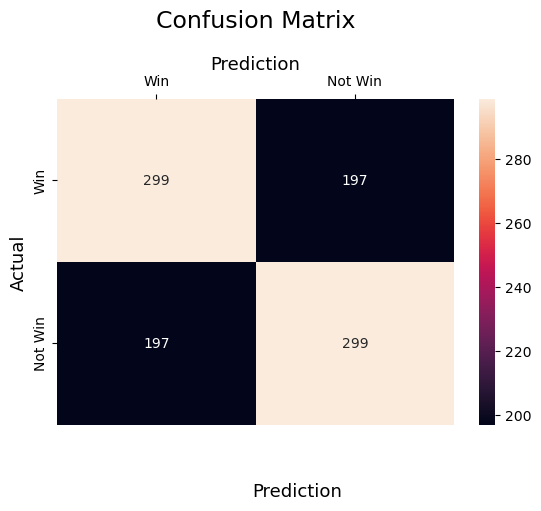

In [1038]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Win','Not Win'], yticklabels=['Win','Not Win'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [1040]:
print(classification_report(actual_array, predicted_array))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       496
           1       0.60      0.60      0.60       496

    accuracy                           0.60       992
   macro avg       0.60      0.60      0.60       992
weighted avg       0.60      0.60      0.60       992



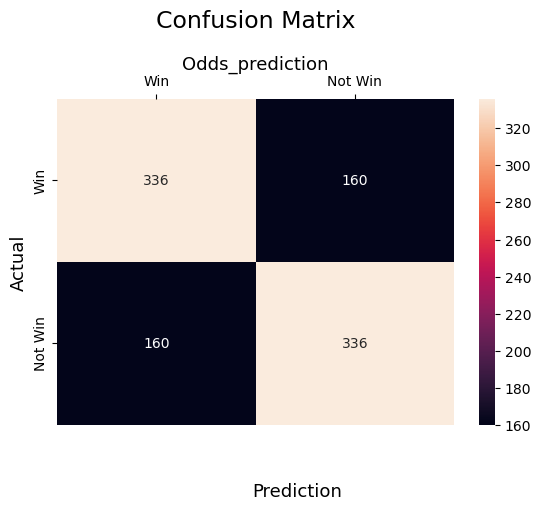

In [1042]:
sns.heatmap(cm_odds, annot=True, fmt='g', xticklabels=['Win','Not Win'], yticklabels=['Win','Not Win'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Odds_prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [1044]:
print(classification_report(actual_array, odds_array))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       496
           1       0.68      0.68      0.68       496

    accuracy                           0.68       992
   macro avg       0.68      0.68      0.68       992
weighted avg       0.68      0.68      0.68       992



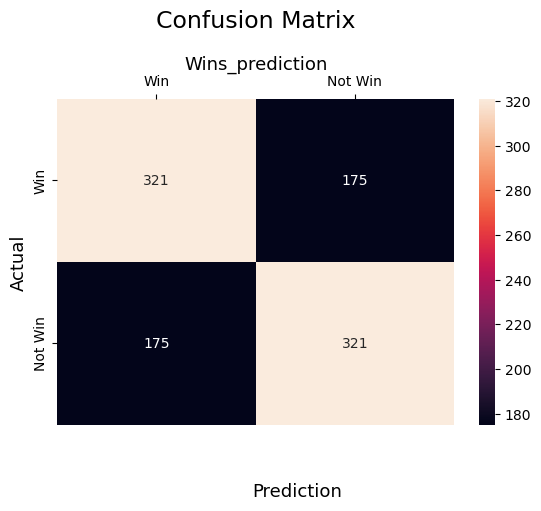

In [1046]:
sns.heatmap(cm_wins, annot=True, fmt='g', xticklabels=['Win','Not Win'], yticklabels=['Win','Not Win'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Wins_prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()